## Autoencoders

** Trying out different types dimensionality reduction techniques using neural networks **

- Numerical inputs
- Categorical (nominal/ordinal) transformed to one-hot representation


** Notes: **

add regularization - Dropout?
Make the network class more general

In [1]:
import numpy as np
import tensorflow as tf
from sklearn import datasets
import math
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
iris_dataset = datasets.load_iris()
wine_dataset = datasets.load_wine()
mushroom_dataset = pd.read_csv(".data/mushrooms_full.csv", sep=";")
mushroom_dataset = mushroom_dataset.dropna()

In [4]:
iris_dataset.keys()

dict_keys(['feature_names', 'data', 'target_names', 'filename', 'DESCR', 'target'])

In [44]:
iris_dataset["feature_names"]

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [4]:
color_mapping = {0: "red", 1: "blue", 2: "green"}


In [3]:
def batch_generator(features, batch_size=50, n_epochs=1000):
    """
    Batch generator for the iris dataset
    """

    # Generate batches
    for epoch in range(n_epochs):
        start_index = 0
        while start_index != -1:
            # Calculate the end index of the batch to generate
            end_index = start_index + batch_size if start_index + batch_size < n else -1

            yield features[start_index:end_index]

            start_index = end_index

In [12]:
# Auto Encoder, simple network
class TF_AutoEncoder:
    def __init__(self, features, labels, dtype=tf.float32):
        self.features = features
        self.labels = labels
        self.dtype = dtype

        self.encoder = dict()

    def fit(self, n_dimensions):
        graph = tf.Graph()
        with graph.as_default():

            # Input variable
            X = tf.placeholder(self.dtype, shape=(None, self.features.shape[1]))

            # Network variables
            encoder_weights = tf.Variable(tf.random_normal(shape=(self.features.shape[1], n_dimensions)))
            encoder_bias = tf.Variable(tf.zeros(shape=[n_dimensions]))

            decoder_weights = tf.Variable(tf.random_normal(shape=(n_dimensions, self.features.shape[1])))
            decoder_bias = tf.Variable(tf.zeros(shape=[self.features.shape[1]]))

            # Encoder part (1 layer)
            encoding = tf.nn.sigmoid(tf.add(tf.matmul(X, encoder_weights), encoder_bias))

            # Decoder part (1 layer)
            predicted_x = tf.nn.sigmoid(tf.add(tf.matmul(encoding, decoder_weights), decoder_bias))

            # Define the cost function and optimizer to minimize squared error
            cost = tf.reduce_mean(tf.pow(tf.subtract(predicted_x, X), 2))
            optimizer = tf.train.AdamOptimizer().minimize(cost)

        with tf.Session(graph=graph) as session:
            # Initialize global variables
            session.run(tf.global_variables_initializer())

            for batch_x in batch_generator(self.features):
                self.encoder['weights'], self.encoder['bias'], _ = session.run([encoder_weights, encoder_bias, optimizer],
                                                                            feed_dict={X: batch_x})

    def reduce(self):
        return np.add(np.matmul(self.features, self.encoder['weights']), self.encoder['bias'])

** Test on Iris **

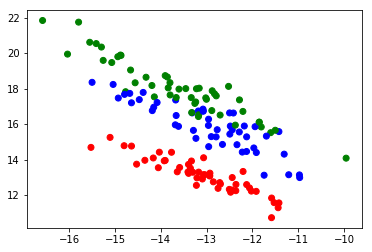

In [30]:
# Mix the data before training
n = len(iris_dataset.data)
random_idx = np.random.permutation(n)
features, labels = iris_dataset.data[random_idx], iris_dataset.target[random_idx]

# Create an instance and encode
tf_ae = TF_AutoEncoder(features, labels)

tf_ae.fit(n_dimensions=4)

auto_encoded = tf_ae.reduce()

colors = list(map(lambda x: color_mapping[x], labels))

plt.scatter(auto_encoded[:, 0], auto_encoded[:, 1], c=colors)

In [31]:
tf_ae.encoder["weights"].shape

(4, 4)

In [14]:
# Auto Encoder, larger network
class TF_AutoEncoder:
    def __init__(self, features, labels, dtype=tf.float32):
        self.features = features
        self.labels = labels
        self.dtype = dtype
        self.epochs = 500
        self.batch_size = 250
        self.encoder = dict()

    def fit(self, n_dim):
        graph = tf.Graph()
        with graph.as_default():

            # Input variable
            X = tf.placeholder(self.dtype, shape=(None, self.features.shape[1]))

            # Network variables - encoder layers
            encoder_weights_1 = tf.Variable(tf.random_normal(shape=(self.features.shape[1], n_dim[0])))
            encoder_bias_1 = tf.Variable(tf.zeros(shape=[n_dim[0]]))
            
            encoder_weights_2 = tf.Variable(tf.random_normal(shape=(n_dim[0], n_dim[1])))
            encoder_bias_2 = tf.Variable(tf.zeros(shape=[n_dim[1]]))
            
            # Network variables - decoder layers
            decoder_weights_1 = tf.Variable(tf.random_normal(shape=(n_dim[1], n_dim[0])))
            decoder_bias_1 = tf.Variable(tf.zeros(shape=[n_dim[0]]))
            
            decoder_weights_2 = tf.Variable(tf.random_normal(shape=(n_dim[0], self.features.shape[1])))
            decoder_bias_2 = tf.Variable(tf.zeros(shape=[self.features.shape[1]]))
            
            # Encoder part (2 layers)
            encoding_1 = tf.nn.relu(tf.add(tf.matmul(X, encoder_weights_1), encoder_bias_1))
            encoding_2 = tf.nn.relu(tf.add(tf.matmul(encoding_1, encoder_weights_2), encoder_bias_2))
            
            # Decoder part (2 layers)
            decoder_1 = tf.nn.relu(tf.add(tf.matmul(encoding_2, decoder_weights_1), decoder_bias_1))
            predicted_x = tf.nn.relu(tf.add(tf.matmul(decoder_1, decoder_weights_2), decoder_bias_2))

            # Define the cost function and optimizer to minimize squared error
            cost = tf.reduce_mean(tf.pow(tf.subtract(predicted_x, X), 2))
            optimizer = tf.train.AdamOptimizer().minimize(cost)

        with tf.Session(graph=graph) as session:
            # Initialize global variables
            session.run(tf.global_variables_initializer())
            
            iter_count = 0
            for batch_x in batch_generator(self.features, self.batch_size, self.epochs):
                self.encoder["weights_0"], self.encoder['bias_0'], self.encoder['weights_1'], self.encoder['bias_1'], _, loss = session.run([encoder_weights_1,
                                                                                                                                        encoder_bias_1,
                                                                                                                                        encoder_weights_2, 
                                                                                                                                        encoder_bias_2,
                                                                                                                                        optimizer, cost],
                                                                                                                                        feed_dict={X: batch_x})
                iter_count += 1
                if iter_count % 500 == 0:
                    print("iter: {}, loss: {}".format(iter_count,loss))
        print(iter_count)
        
    def reduce(self):
        layer_1 = np.add(np.matmul(self.features, self.encoder['weights_0']), self.encoder['bias_0'])
        activation = np.maximum(layer_1, 0, layer_1)
        print(layer_1.shape)
        return np.add(np.matmul(activation, self.encoder['weights_1']), self.encoder['bias_1'])

### Slightly larger dataset in terms of variables, numerical input

In [37]:
# Mix the data before training
n = len(wine_dataset.data)
random_idx = np.random.permutation(n)
features, labels = wine_dataset.data[random_idx], wine_dataset.target[random_idx]

# Create an instance and encode
tf_ae = TF_AutoEncoder(features, labels)

tf_ae.fit(n_dim=[8,4])



iter: 500, loss: 50687.9296875
500


In [16]:
auto_encoded = tf_ae.reduce()

(178, 8)


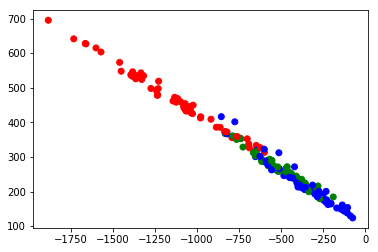

In [22]:
colors = list(map(lambda x: color_mapping[x], labels))

plt.scatter(auto_encoded[:, 1], auto_encoded[:, 3], c=colors)

In [71]:
print(tf_ae.features.shape)
print(tf_ae.encoder["weights_1"].shape)
print(tf_ae.encoder["bias_1"].shape)
print(auto_encoded.shape)


(178, 13)
(10, 5)
(5,)
(178, 5)


### Categorical input

In [11]:
mushroom_dataset.describe()

,label,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [29]:
mushrooms_part = mushroom_dataset[["cap-shape", "cap-surface"]]
mushrooms_dummies = pd.get_dummies(mushrooms_part)
mushrooms_dummies.head()


,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y
0,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,1,0,0,1,0
2,1,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,1
4,0,0,0,0,0,1,0,0,1,0


In [30]:
# Mix the data before training
n = len(mushrooms_dummies)
random_idx = np.random.permutation(n)
features, labels = mushrooms_dummies.loc[random_idx,:], mushroom_dataset.loc[random_idx, "label"]

# Create an instance and encode
tf_ae = TF_AutoEncoder(features, labels)

tf_ae.fit(n_dim=[6,2])


iter: 500, loss: 0.2016386240720749
iter: 1000, loss: 0.18955375254154205
iter: 1500, loss: 0.18822568655014038
iter: 2000, loss: 0.18683159351348877
iter: 2500, loss: 0.18604055047035217
iter: 3000, loss: 0.18562081456184387
iter: 3500, loss: 0.18653236329555511
iter: 4000, loss: 0.18196052312850952
iter: 4500, loss: 0.19022859632968903
iter: 5000, loss: 0.18676166236400604
iter: 5500, loss: 0.18666218221187592
iter: 6000, loss: 0.18902263045310974
iter: 6500, loss: 0.1894744336605072
iter: 7000, loss: 0.18393130600452423
iter: 7500, loss: 0.1866980940103531
iter: 8000, loss: 0.19092172384262085
iter: 8500, loss: 0.18539248406887054
iter: 9000, loss: 0.18428662419319153
iter: 9500, loss: 0.18478989601135254
iter: 10000, loss: 0.18462544679641724
iter: 10500, loss: 0.18486972153186798
iter: 11000, loss: 0.18673963844776154
iter: 11500, loss: 0.18722787499427795
iter: 12000, loss: 0.1876508593559265
iter: 12500, loss: 0.1877484917640686
iter: 13000, loss: 0.18544766306877136
iter: 13500

In [31]:
auto_encoded = tf_ae.reduce()

(8124, 6)


In [32]:
auto_encoded[:11,:]

array([[-3.2631762 , -1.1080458 ],
       [-6.763222  , -2.1008613 ],
       [-2.333699  ,  1.9454173 ],
       [-6.763222  , -2.1008613 ],
       [-2.333699  ,  1.9454173 ],
       [-8.222956  , -2.413523  ],
       [-1.343277  , -0.59373045],
       [-8.222956  , -2.413523  ],
       [-1.343277  , -0.59373045],
       [-2.0877492 , -0.6947862 ],
       [-6.763222  , -2.1008613 ]], dtype=float32)

In [33]:
features.reset_index(drop=True).loc[:10, :]

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y
0,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,1
2,0,0,1,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,1
4,0,0,1,0,0,0,0,0,1,0
5,0,0,1,0,0,0,0,0,0,1
6,0,0,0,0,0,1,1,0,0,0
7,0,0,1,0,0,0,0,0,0,1
8,0,0,0,0,0,1,1,0,0,0
9,0,0,0,0,0,1,0,0,1,0


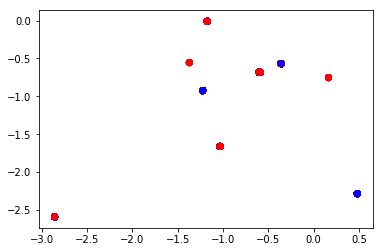

In [22]:
color_mapping = {"e": "red", "p": "blue"}
colors = list(map(lambda x: color_mapping[x], labels))

plt.scatter(auto_encoded[:, 0], auto_encoded[:, 1], c=colors)